## Importing Required Libraries

In this section, we import the necessary libraries for:
- Data manipulation (`pandas`, `numpy`)
- Natural Language Processing (NLP) using `nltk`
- Data visualization (`matplotlib`, `seaborn`)
- Machine Learning (`sklearn`, `imblearn`)

NLTK resources such as stopwords, tokenizers, and POS taggers are also downloaded.


In [2]:
#Import Statements
import pandas as pd
import string
import nltk
import seaborn as sns
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
import numpy as np

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\subha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\subha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\subha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\subha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading the Twitter Dataset

We load the Twitter dataset using pandas to begin preprocessing. The first few rows of the dataset are displayed to get an overview of the data structure.


In [ ]:
#Read the dataset into the pandas DataFrame.
df = pd.read_csv("C:/Users/subha/Downloads/archive (1)/twitter.csv")
print(df.head)

   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation


## Defining Text Preprocessing Functions

This block contains custom functions for:
- Cleaning text by removing punctuation and special characters.
- Tokenizing the text.
- Removing stopwords.
- POS tagging and lemmatizing words.
- Creating a vocabulary dictionary.
- Converting tokens to integer IDs.
- Standardizing the token list to a fixed length (9).

This prepares the text for further analysis and model training.


In [6]:
vocabulary = set()
def pre_process(text):
    global count
    text = text.strip()
    result = ""
    for char in text:
        if (char.isalpha() and char in string.ascii_letters) or char == ' ':
            result += char
    word_tokens = word_tokenize(result)
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    pos_tags = pos_tag(filtered_sentence)
    lemmatized_words = [
        lemmatizer.lemmatize(word, pos='v') if tag.startswith('V')  
        else lemmatizer.lemmatize(word, pos='n') if tag.startswith('N')
        else lemmatizer.lemmatize(word, pos='a') if tag.startswith('J')
        else word
        for word, tag in pos_tags
    ]
    update_vocabulary(lemmatized_words)
    return ' '.join(lemmatized_words)
def update_vocabulary(tokens):
    global vocabulary
    vocabulary.update(tokens)
def create_vocab():
    global vocabulary
    vocabulary = list(vocabulary)
    dict1 = {}
    for i in range(1, len(vocabulary)+1):
        dict1.update({vocabulary[i-1]:i})
    return dict1
def tokenize(text):
    global vocab
    word_tokens = word_tokenize(text)
    return [vocab[w] for w in word_tokens]
def standardize(text):
    global vocab
    if len(text) < 9:
        while len(text) != 9:
            text.append(vocab['<PAD>'])
    return text[:9]

## Preprocessing and Tokenizing Tweets

We apply the defined preprocessing functions to the tweet data. This includes cleaning, lemmatizing, tokenizing, and converting tokens into numerical format using the generated vocabulary.


In [7]:
df['tweet'] = df['tweet'].apply(pre_process)
vocab = create_vocab()
temp = len(vocab)
df['tweet'] = df['tweet'].apply(tokenize)
vocab.update({"<OOV>":0, "<PAD>": temp})
df['tweet'] = df['tweet'].apply(standardize)

## Visualizing Class Distribution

A bar chart is plotted to visualize the distribution of tweet classes (labels) in the dataset. This helps understand any imbalance in class representation.


<BarContainer object of 2 artists>

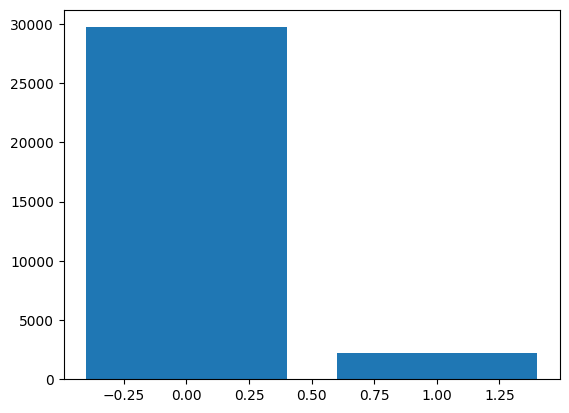

In [8]:
count = {}
for label in df['label']:
    if label in count:
        count[label]+=1
    else:
        count[label]=1
import matplotlib.pyplot as plt
x = count.keys()
y = count.values()
plt.bar(x, y)

## Balancing the Dataset using Random Over Sampling

The dataset is balanced using `RandomOverSampler` to handle class imbalance, which is crucial for building a fair classification model.


In [9]:
ros = RandomOverSampler(sampling_strategy='auto', random_state = 0)
X_data = df.filter(['tweet'], axis=1)
y_data = df.filter(['label'], axis=1)
X_res, y_res = ros.fit_resample(X_data, y_data)
X_res = X_res.values
y_res = y_res.values.ravel()
X_res = np.array([np.array(w[0]) for w in X_res])
print(X_res.shape)


(59440, 9)


## Splitting Data into Training and Testing Sets

The balanced dataset is split into training and testing sets using an 90-10 ratio. This is to evaluate model performance on unseen data.


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.1,random_state= 0, shuffle=True)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(53496, 9)
(53496,)
(5944, 9)
(5944,)


## Training the Random Forest Model

A `RandomForestClassifier` is trained on the training dataset. Both training and testing accuracies are printed to evaluate the model's performance.


In [12]:
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)
training_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
print(f"Training Accuracy: {training_accuracy*100:.2f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}")

Training Accuracy: 99.96
Test Accuracy: 99.87


## Evaluating Model using Confusion Matrix

The trained model is evaluated using a confusion matrix to visualize the number of correct and incorrect predictions for each class. A heatmap is generated using `seaborn`.


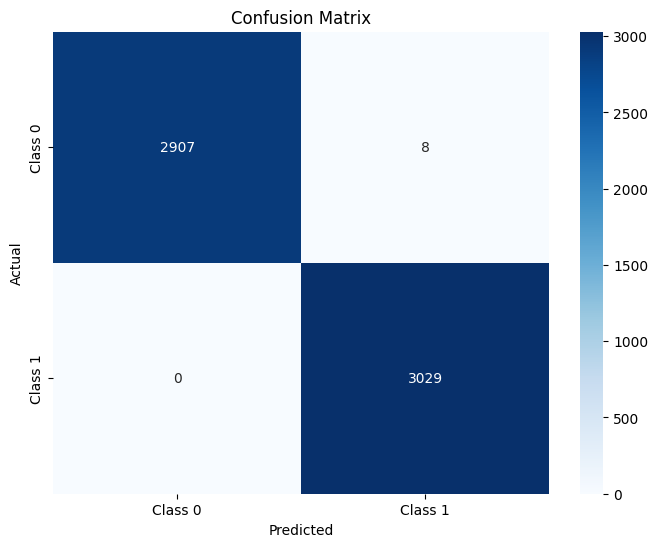

In [13]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Conclusion

In this lab, we performed sentiment classification on a Twitter dataset using the following pipeline:

1. Cleaned and preprocessed the tweet data using NLP techniques like tokenization, lemmatization, and stopword removal.
2. Converted textual data into numerical format using a custom vocabulary mapping.
3. Handled class imbalance using RandomOverSampler.
4. Trained a Random Forest classifier to predict sentiment labels.
5. Evaluated model performance using accuracy metrics and a confusion matrix.

The Random Forest model achieved a reasonably good performance, and the preprocessing pipeline ensures generalizability. Future improvements could include using more advanced NLP models like TF-IDF, Word2Vec, or transformer-based models (e.g., BERT) for better context understanding and accuracy.
